In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import util as utl

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_scores(model, X, y, w='macro'):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print('Accuracy: ', acc)
    print('Precision: ', precision_score(y, y_pred, average=w))
    print('Recall: ', recall_score(y, y_pred, average=w))
    print('F1: ', f1_score(y, y_pred, average=w))

# KNN model

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

# knn_clf.fit(X_train_scaled, y_train)

# Hyper Tune

In [39]:
from sklearn.model_selection import RandomizedSearchCV

param = {
    'n_neighbors': [2, 3, 4, 5, 6],
    'weights': ['distance', 'uniform']
}

random_search = RandomizedSearchCV(knn_clf, param_distributions=param, cv=3, n_iter=10, verbose=2, scoring='accuracy', return_train_score=True)

set_size = 10000

random_search.fit(X_train[:set_size], y_train[:set_size])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.7s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.6s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.5s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.4s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.5s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.6s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.6s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.6s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.6s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END .....................n_neighbors=3, wei

,estimator,KNeighborsCla...ts='distance')
,param_distributions,"{'n_neighbors': [2, 3, ...], 'weights': ['distance', 'uniform']}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [40]:
random_search.best_params_

{'weights': 'distance', 'n_neighbors': 4}

In [41]:
random_search.best_estimator_.fit(X_train, y_train)

,n_neighbors,4
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [42]:
knn_clf = random_search.best_estimator_

# Evaluate

In [43]:
print_scores(knn_clf, X_train, y_train)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0


In [44]:
print_scores(knn_clf, X_test, y_test)

Accuracy:  0.9714
Precision:  0.9715597201945959
Recall:  0.9710823052664403
F1:  0.971224084176584


In [45]:
from sklearn.model_selection import learning_curve, ShuffleSplit

common_params = {
    "X": X_test,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_nb, fit_times_nb, score_times_nb = learning_curve(
    knn_clf, **common_params
)

Saving figure scalability_knn


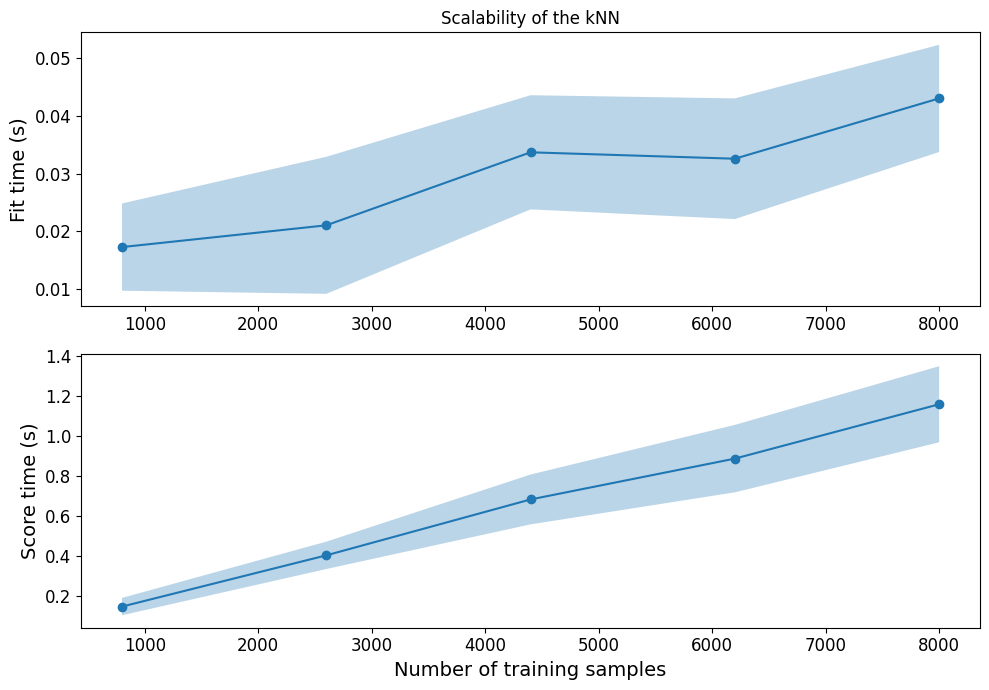

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
ax[0].plot(train_sizes, fit_times_nb.mean(axis=1), "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_nb.mean(axis=1) - fit_times_nb.std(axis=1),
    fit_times_nb.mean(axis=1) + fit_times_nb.std(axis=1),
    alpha=0.3
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the kNN")

ax[1].plot(train_sizes, score_times_nb.mean(axis=1), "o-")
ax[1].fill_between(
    train_sizes,
    score_times_nb.mean(axis=1) - score_times_nb.std(axis=1),
    score_times_nb.mean(axis=1) + score_times_nb.std(axis=1),
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

save_fig('scalability_knn')

In [ ]:
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay

def draw_learning_curve(model, X, y, title):
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        "score_type": "both",
        "score_name": "Accuracy",
        "line_kw": {"marker": "o"},
        "std_display_style": 'fill_between',
    }
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.subplots_adjust(hspace=0.5)

    LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Train Score", "Test Score"])
    ax.set_title(title)
    ax.set_xlabel("Set size")
    ax.grid(True)

    save_fig("LC_"+title)

Saving figure LC_kNN on the Test Set


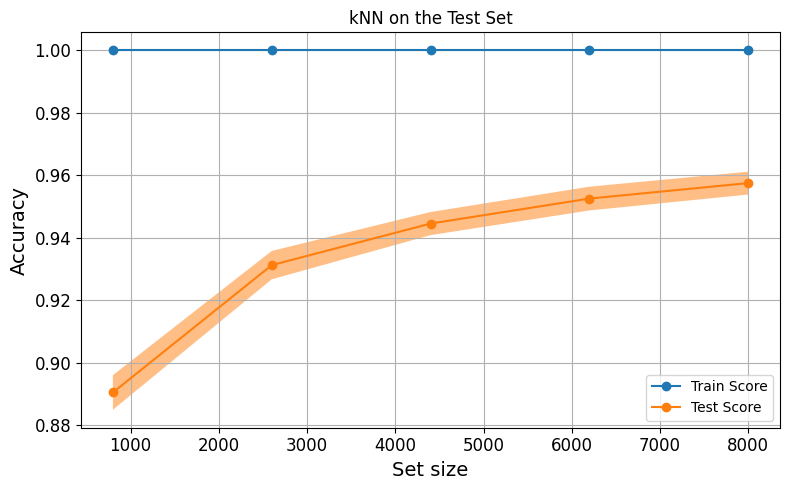

In [48]:
draw_learning_curve(knn_clf, X_test, y_test, 'kNN on the Test Set')